# D-OPS-2 — Resource Allocation
## Medicare Integrity Decision Support Framework

**Decision Owner:** CPI Director / Program Integrity Resource Manager
**Primary Owner:** Center for Program Integrity (CPI) — Director's Office
**Supporting Owner:** Office of Enterprise Data and Analytics (OEDA)
**Cadence:** Quarterly resource allocation review
**Data:** CMS Medicare Part B PUF, Reporting Year 2025, Data Year 2023 (RY25/D23)

---

### What This Notebook Does

This notebook translates the D-OPS-1 monitoring roster (61,416 providers across
three intensity levels) into structured resource allocation guidance for CPI
leadership. It estimates workload demand by monitoring intensity level, quantifies
dollar exposure concentration, and produces a prioritized allocation framework
across nine Level × Pathway cells.

Resource estimates are parameterized. All allocation outputs describe statistical
patterns derived from analytical inputs. No output constitutes an operational
budget decision or staffing directive.

### What This Notebook Does Not Do

- Does not assign staff to individual providers
- Does not assert that any provider committed fraud, waste, or abuse
- Does not produce binding resource commitments
- Does not replace CPI Director operational judgment

### Monitoring Intensity Level Reference

| Level | Label | D-OPS-1 Count | Dollar Exposure |
|---|---|---|---|
| Level 1 | Active Surveillance | 1,162 providers | $0.51B |
| Level 2 | Periodic Review | 1,613 providers | $0.26B |
| Level 3 | Passive Surveillance | 58,641 providers | $6.35B |

### Output Tagging Standard

| Tag | Meaning |
|---|---|
| O | Observed — directly in the data |
| D | Derived — mathematically constructed from observed data |
| I | Inferred — evidence-based pattern interpretation |
| A | Assumed — declared gap-filling for decision support |

**No output may assert provider intent, fraud, or wrongdoing.**

---

*Organizational roles sourced from CMS Org Chart, April 22, 2025.*
*All analytical outputs describe statistical patterns only.*
*No outputs constitute findings of fraud, waste, or abuse.*

In [8]:
# =============================================================================
# DOPS2-00-CONFIG-01 — Imports, Paths, Parameters
# All thresholds, weights, and assumptions parameterized here.
# No hardcoded variables elsewhere in notebook.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# -----------------------------------------------------------------------------
# PROJECT PATHS
# -----------------------------------------------------------------------------
PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
OUTPUT_FIGURES = PROJECT_ROOT / "outputs" / "figures"
OUTPUT_BRIEFS  = PROJECT_ROOT / "outputs" / "decision_briefs"

# -----------------------------------------------------------------------------
# INPUT FILE
# -----------------------------------------------------------------------------
F_ROSTER = DATA_PROCESSED / "monitoring_roster_v1.parquet"

# -----------------------------------------------------------------------------
# REPRODUCIBILITY
# -----------------------------------------------------------------------------
RANDOM_STATE = 42

# -----------------------------------------------------------------------------
# PRINT WIDTH
# -----------------------------------------------------------------------------
PRINT_WIDTH = 88
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", PRINT_WIDTH)

# -----------------------------------------------------------------------------
# MONITORING INTENSITY LEVELS
# -----------------------------------------------------------------------------
MONITOR_LEVELS = {
    "Level_1": "Active Surveillance",
    "Level_2": "Periodic Review",
    "Level_3": "Passive Surveillance",
}

# -----------------------------------------------------------------------------
# RESOURCE ASSUMPTION PARAMETERS (tag A — operational assumptions)
# Rationale: No CMS staffing actuals available in public data.
# Assumptions declared explicitly and parameterized for sensitivity analysis.
# -----------------------------------------------------------------------------

# Estimated staff review hours per provider per quarter by intensity level
HOURS_L1 = 8.0    # Level 1 — Active Surveillance: full case review cycle
HOURS_L2 = 4.0    # Level 2 — Periodic Review: structured follow-through
HOURS_L3 = 0.5    # Level 3 — Passive Surveillance: automated flag + log

# FTE capacity assumption (hours available per FTE per quarter)
HOURS_PER_FTE = 480.0  # 40 hrs/week × 12 weeks (one quarter)

# Case slot capacity (max active cases per investigator per quarter)
CASE_SLOTS_PER_INVESTIGATOR = 20  # L1 cases only

# Abstract Capacity Unit (ACU) weights — normalized effort index
ACU_L1 = 1.00
ACU_L2 = 0.50
ACU_L3 = 0.063  # 0.5 / 8.0 — proportional to hours ratio

# -----------------------------------------------------------------------------
# IBM CARBON CVD PALETTE
# -----------------------------------------------------------------------------
CVD_PALETTE = {
    "Level_1": "#DC267F",   # magenta  — Active Surveillance
    "Level_2": "#FFB000",   # amber    — Periodic Review
    "Level_3": "#648FFF",   # blue     — Passive Surveillance
    "Other":   "#BBBBBB",   # gray
}

# -----------------------------------------------------------------------------
# CONFIRM CONFIG
# -----------------------------------------------------------------------------
print("=" * PRINT_WIDTH)
print("D-OPS-2 RESOURCE ALLOCATION — CONFIG LOADED")
print("=" * PRINT_WIDTH)
print(f"  Input file : {F_ROSTER}")
print(f"  Hours L1   : {HOURS_L1} hrs/provider/quarter")
print(f"  Hours L2   : {HOURS_L2} hrs/provider/quarter")
print(f"  Hours L3   : {HOURS_L3} hrs/provider/quarter")
print(f"  FTE cap    : {HOURS_PER_FTE} hrs/FTE/quarter")
print(f"  Case slots : {CASE_SLOTS_PER_INVESTIGATOR} L1 cases/investigator")
print(f"  ACU L1/L2/L3: {ACU_L1} / {ACU_L2} / {ACU_L3:.3f}")
print("=" * PRINT_WIDTH)

D-OPS-2 RESOURCE ALLOCATION — CONFIG LOADED
  Input file : C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\monitoring_roster_v1.parquet
  Hours L1   : 8.0 hrs/provider/quarter
  Hours L2   : 4.0 hrs/provider/quarter
  Hours L3   : 0.5 hrs/provider/quarter
  FTE cap    : 480.0 hrs/FTE/quarter
  Case slots : 20 L1 cases/investigator
  ACU L1/L2/L3: 1.0 / 0.5 / 0.063


In [9]:
# =============================================================================
# DOPS2-01-LOAD-01 — Load Monitoring Roster
# Load monitoring_roster_v1.parquet. No transformations — load and confirm only.
# =============================================================================

df_roster = pd.read_parquet(F_ROSTER)

print("=" * PRINT_WIDTH)
print("DOPS2-01-LOAD-01 — MONITORING ROSTER LOADED")
print("=" * PRINT_WIDTH)
print(f"  Rows       : {len(df_roster):,}")
print(f"  Columns    : {df_roster.columns.tolist()}")
print(f"  Nulls      : {df_roster.isnull().sum().sum()}")
print()
print(df_roster.dtypes)
print()
print(df_roster.head(3))
print("=" * PRINT_WIDTH)

DOPS2-01-LOAD-01 — MONITORING ROSTER LOADED
  Rows       : 61,416
  Columns    : ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'tier_source', 'pathway', 'allowed_dollars_sum', 'monitoring_score', 'monitoring_level']
  Nulls      : 0

Rndrng_NPI              object
Rndrng_Prvdr_Type       object
tier_source             object
pathway                 object
allowed_dollars_sum    float64
monitoring_score       float64
monitoring_level        object
dtype: object

   Rndrng_NPI                               Rndrng_Prvdr_Type tier_source  \
0  1427320399  Independent Diagnostic Testing Facility (IDTF)       Tier1   
1  1215003603                             Clinical Laboratory       Tier1   
2  1013973866                             Clinical Laboratory       Tier1   

                     pathway  allowed_dollars_sum  monitoring_score  \
0  Provider Education Letter         1.321297e+08          0.395545   
1           OIG/DOJ Referral         9.394750e+07          0.699999   
2  Provider Education 

In [10]:
# =============================================================================
# DOPS2-02-VALIDATE-01 — Integrity Checks
# Six checks before any analysis. Assertion failures halt notebook.
# Note: pathway value for Tier 2 providers is 'Tier 2 Only' (with spaces).
# Confirmed via diagnostic 2026-03-01. Recorded in decision log DL-DOPS2-XX.
# =============================================================================

# Check 1 — No duplicate NPIs
assert df_roster["Rndrng_NPI"].nunique() == len(df_roster), \
    "FAIL: Duplicate NPIs in monitoring roster"
print("CHECK 1 PASS — No duplicate NPIs")

# Check 2 — Row count matches D-OPS-1 known output
EXPECTED_ROWS = 61_416
assert len(df_roster) == EXPECTED_ROWS, \
    f"FAIL: Expected {EXPECTED_ROWS:,} rows, got {len(df_roster):,}"
print(f"CHECK 2 PASS — Row count confirmed at {len(df_roster):,}")

# Check 3 — monitoring_level values match expected set
EXPECTED_LEVELS = {
    "Level 1 — Active Surveillance",
    "Level 2 — Periodic Review",
    "Level 3 — Passive Surveillance",
}
actual_levels = set(df_roster["monitoring_level"].unique())
assert actual_levels == EXPECTED_LEVELS, \
    f"FAIL: Unexpected monitoring_level values: {actual_levels - EXPECTED_LEVELS}"
print(f"CHECK 3 PASS — monitoring_level values: {sorted(actual_levels)}")

# Check 4 — pathway values match expected set
# Note: Tier 2 pathway label is 'Tier 2 Only' (spaces, not underscore)
EXPECTED_PATHWAYS = {
    "OIG/DOJ Referral",
    "Targeted Probe and Educate",
    "Provider Education Letter",
    "Tier 2 Only",
}
actual_pathways = set(df_roster["pathway"].unique())
assert actual_pathways == EXPECTED_PATHWAYS, \
    f"FAIL: Unexpected pathway values: {actual_pathways - EXPECTED_PATHWAYS}"
print(f"CHECK 4 PASS — pathway values: {sorted(actual_pathways)}")

# Check 5 — No negative allowed_dollars_sum
assert (df_roster["allowed_dollars_sum"] >= 0).all(), \
    "FAIL: Negative values in allowed_dollars_sum"
print("CHECK 5 PASS — No negative allowed dollars")

# Check 6 — monitoring_score in [0, 1]
assert df_roster["monitoring_score"].between(0, 1).all(), \
    "FAIL: monitoring_score out of [0,1] range"
print("CHECK 6 PASS — monitoring_score bounded in [0, 1]")

print()
print("=" * PRINT_WIDTH)
print("ALL CHECKS PASSED — roster ready for analysis")
print("=" * PRINT_WIDTH)

CHECK 1 PASS — No duplicate NPIs
CHECK 2 PASS — Row count confirmed at 61,416
CHECK 3 PASS — monitoring_level values: ['Level 1 — Active Surveillance', 'Level 2 — Periodic Review', 'Level 3 — Passive Surveillance']
CHECK 4 PASS — pathway values: ['OIG/DOJ Referral', 'Provider Education Letter', 'Targeted Probe and Educate', 'Tier 2 Only']
CHECK 5 PASS — No negative allowed dollars
CHECK 6 PASS — monitoring_score bounded in [0, 1]

ALL CHECKS PASSED — roster ready for analysis


## Data Preparation

### Column Format Discovery — pathway label for Tier 2 providers

The `pathway` column uses the label `'Tier 2 Only'` (with spaces) for providers
sourced from D-PI-1 Tier 2 who were not routed through D-PI-2. This differs from
the underscore form `'Tier2_Only'` assumed in initial notebook design.

Confirmed via DOPS2-02-VALIDATE-01 diagnostic, 2026-03-01.
Recorded in decision log DL-DOPS2-XX.

All downstream cells use the confirmed string form `'Tier 2 Only'`.

In [11]:
# =============================================================================
# DOPS2-03-PREP-01 — Build Working Dataset
# Add short level key, pathway short label, and resource columns.
# All derived from CONFIG parameters — no hardcoded values.
# =============================================================================

df_work = df_roster.copy()

# -----------------------------------------------------------------------------
# SHORT LEVEL KEY — for groupby and charting
# -----------------------------------------------------------------------------
LEVEL_SHORT = {
    "Level 1 — Active Surveillance": "Level_1",
    "Level 2 — Periodic Review":     "Level_2",
    "Level 3 — Passive Surveillance":"Level_3",
}
df_work["level_key"] = df_work["monitoring_level"].map(LEVEL_SHORT)

# -----------------------------------------------------------------------------
# SHORT PATHWAY LABEL — for groupby and charting
# -----------------------------------------------------------------------------
PATHWAY_SHORT = {
    "OIG/DOJ Referral":           "OIG",
    "Targeted Probe and Educate": "TPE",
    "Provider Education Letter":  "EdLetter",
    "Tier 2 Only":                "Tier2",
}
df_work["pathway_short"] = df_work["pathway"].map(PATHWAY_SHORT)

# -----------------------------------------------------------------------------
# REVIEW HOURS PER PROVIDER (tag A)
# -----------------------------------------------------------------------------
HOURS_MAP = {
    "Level_1": HOURS_L1,
    "Level_2": HOURS_L2,
    "Level_3": HOURS_L3,
}
df_work["review_hours"] = df_work["level_key"].map(HOURS_MAP)

# -----------------------------------------------------------------------------
# ABSTRACT CAPACITY UNITS PER PROVIDER (tag A)
# -----------------------------------------------------------------------------
ACU_MAP = {
    "Level_1": ACU_L1,
    "Level_2": ACU_L2,
    "Level_3": ACU_L3,
}
df_work["acu"] = df_work["level_key"].map(ACU_MAP)

# -----------------------------------------------------------------------------
# CONFIRM
# -----------------------------------------------------------------------------
print("=" * PRINT_WIDTH)
print("DOPS2-03-PREP-01 — WORKING DATASET BUILT")
print("=" * PRINT_WIDTH)
print(f"  Rows    : {len(df_work):,}")
print(f"  Columns : {df_work.columns.tolist()}")
print()
print("Level key counts:")
print(df_work["level_key"].value_counts())
print()
print("Pathway short counts:")
print(df_work["pathway_short"].value_counts())
print()
print("Nulls in new columns:")
print(df_work[["level_key","pathway_short","review_hours","acu"]].isnull().sum())
print("=" * PRINT_WIDTH)

DOPS2-03-PREP-01 — WORKING DATASET BUILT
  Rows    : 61,416
  Columns : ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'tier_source', 'pathway', 'allowed_dollars_sum', 'monitoring_score', 'monitoring_level', 'level_key', 'pathway_short', 'review_hours', 'acu']

Level key counts:
level_key
Level_3    58641
Level_2     1613
Level_1     1162
Name: count, dtype: int64

Pathway short counts:
pathway_short
Tier2       39016
EdLetter    19218
TPE          2527
OIG           655
Name: count, dtype: int64

Nulls in new columns:
level_key        0
pathway_short    0
review_hours     0
acu              0
dtype: int64


In [12]:
# =============================================================================
# DOPS2-04-WORKLOAD-01 — Workload Demand by Monitoring Level
# Aggregate review hours, FTE demand, and dollar exposure by level_key.
# All resource estimates tag A (operational assumptions from CONFIG).
# =============================================================================

# -----------------------------------------------------------------------------
# LEVEL SUMMARY TABLE
# -----------------------------------------------------------------------------
level_summary = (
    df_work.groupby("level_key")
    .agg(
        provider_count   = ("Rndrng_NPI",          "count"),
        total_hours      = ("review_hours",          "sum"),
        total_acu        = ("acu",                   "sum"),
        total_dollars    = ("allowed_dollars_sum",   "sum"),
    )
    .reindex(["Level_1", "Level_2", "Level_3"])  # enforce display order
    .reset_index()
)

# FTE demand = total hours / hours per FTE per quarter
level_summary["fte_demand"] = level_summary["total_hours"] / HOURS_PER_FTE

# Dollar exposure in billions
level_summary["dollars_billions"] = level_summary["total_dollars"] / 1e9

# Provider share and dollar share
level_summary["pct_providers"] = (
    level_summary["provider_count"] / level_summary["provider_count"].sum() * 100
)
level_summary["pct_dollars"] = (
    level_summary["dollars_billions"] / level_summary["dollars_billions"].sum() * 100
)

print("=" * PRINT_WIDTH)
print("DOPS2-04-WORKLOAD-01 — WORKLOAD DEMAND BY MONITORING LEVEL")
print("=" * PRINT_WIDTH)
print()
print(
    level_summary[[
        "level_key", "provider_count", "pct_providers",
        "total_hours", "fte_demand",
        "dollars_billions", "pct_dollars",
    ]].to_string(index=False, float_format=lambda x: f"{x:,.2f}")
)
print()
print(f"  Total providers : {level_summary['provider_count'].sum():,}")
print(f"  Total hours     : {level_summary['total_hours'].sum():,.1f}")
print(f"  Total FTE demand: {level_summary['fte_demand'].sum():,.2f} FTEs/quarter")
print(f"  Total exposure  : ${level_summary['dollars_billions'].sum():,.2f}B")
print("=" * PRINT_WIDTH)

DOPS2-04-WORKLOAD-01 — WORKLOAD DEMAND BY MONITORING LEVEL

level_key  provider_count  pct_providers  total_hours  fte_demand  dollars_billions  pct_dollars
  Level_1            1162           1.89     9,296.00       19.37              0.51         7.13
  Level_2            1613           2.63     6,452.00       13.44              0.26         3.67
  Level_3           58641          95.48    29,320.50       61.08              6.35        89.20

  Total providers : 61,416
  Total hours     : 45,068.5
  Total FTE demand: 93.89 FTEs/quarter
  Total exposure  : $7.12B


In [13]:
# =============================================================================
# DOPS2-05-WORKLOAD-02 — Workload Demand by Level × Pathway Cell
# Nine cells: Level_1/2/3 × OIG/TPE/EdLetter/Tier2.
# Not all cells will be populated — some combinations are structurally empty.
# =============================================================================

cell_summary = (
    df_work.groupby(["level_key", "pathway_short"])
    .agg(
        provider_count = ("Rndrng_NPI",         "count"),
        total_hours    = ("review_hours",         "sum"),
        fte_demand     = ("review_hours",         lambda x: x.sum() / HOURS_PER_FTE),
        total_dollars  = ("allowed_dollars_sum",  "sum"),
    )
    .reset_index()
)

cell_summary["dollars_billions"] = cell_summary["total_dollars"] / 1e9

# Enforce level order for display
level_order   = ["Level_1", "Level_2", "Level_3"]
pathway_order = ["OIG", "TPE", "EdLetter", "Tier2"]
cell_summary["level_key"]     = pd.Categorical(cell_summary["level_key"],     categories=level_order,   ordered=True)
cell_summary["pathway_short"] = pd.Categorical(cell_summary["pathway_short"], categories=pathway_order, ordered=True)
cell_summary = cell_summary.sort_values(["level_key", "pathway_short"]).reset_index(drop=True)

print("=" * PRINT_WIDTH)
print("DOPS2-05-WORKLOAD-02 — WORKLOAD BY LEVEL × PATHWAY CELL")
print("=" * PRINT_WIDTH)
print()
print(
    cell_summary[[
        "level_key", "pathway_short", "provider_count",
        "total_hours", "fte_demand", "dollars_billions",
    ]].to_string(index=False, float_format=lambda x: f"{x:,.2f}")
)
print()
print(f"  Populated cells : {len(cell_summary)} of 12 possible")
print("=" * PRINT_WIDTH)

DOPS2-05-WORKLOAD-02 — WORKLOAD BY LEVEL × PATHWAY CELL

level_key pathway_short  provider_count  total_hours  fte_demand  dollars_billions
  Level_1           OIG             606     4,848.00       10.10              0.36
  Level_1           TPE             556     4,448.00        9.27              0.14
  Level_2           OIG              49       196.00        0.41              0.01
  Level_2           TPE            1564     6,256.00       13.03              0.26
  Level_3           TPE             407       203.50        0.42              0.03
  Level_3      EdLetter           19218     9,609.00       20.02              3.49
  Level_3         Tier2           39016    19,508.00       40.64              2.82

  Populated cells : 7 of 12 possible


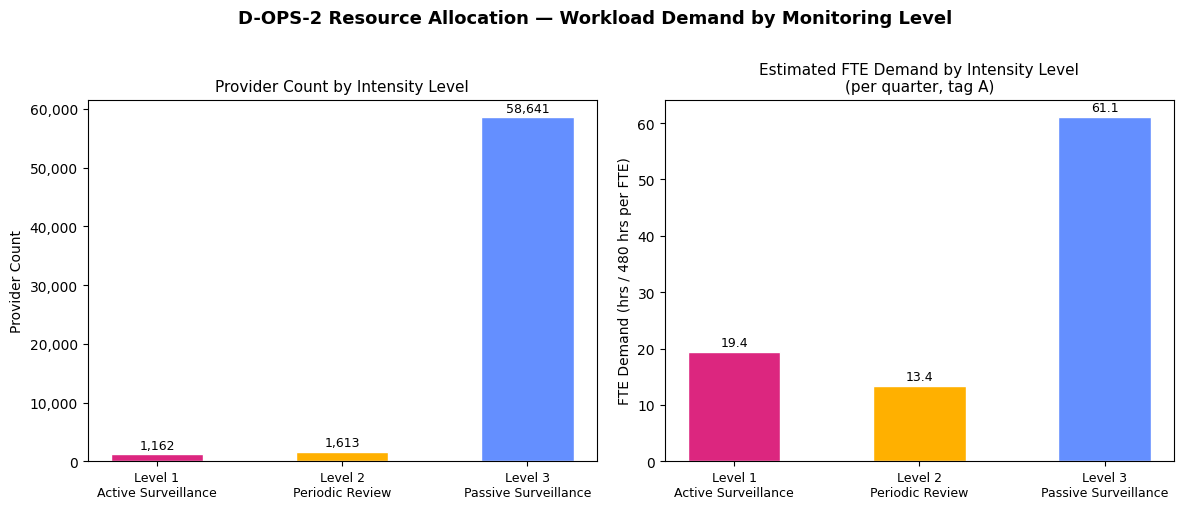

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\resource_workload_summary_v1.png


In [14]:
# =============================================================================
# DOPS2-06-VIZ-01 — Workload Summary Chart
# Two-panel bar chart: provider count and FTE demand by monitoring level.
# CVD-compliant IBM Carbon palette.
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    "D-OPS-2 Resource Allocation — Workload Demand by Monitoring Level",
    fontsize=13, fontweight="bold", y=1.01
)

levels      = level_summary["level_key"].tolist()
colors      = [CVD_PALETTE[lk] for lk in levels]
x           = range(len(levels))
level_labels = ["Level 1\nActive Surveillance", "Level 2\nPeriodic Review", "Level 3\nPassive Surveillance"]

# --- Panel 1: Provider Count ---
ax1 = axes[0]
bars1 = ax1.bar(x, level_summary["provider_count"], color=colors, edgecolor="white", width=0.5)
ax1.set_title("Provider Count by Intensity Level", fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(level_labels, fontsize=9)
ax1.set_ylabel("Provider Count")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{int(v):,}"))
for bar, val in zip(bars1, level_summary["provider_count"]):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 400,
        f"{int(val):,}",
        ha="center", va="bottom", fontsize=9
    )

# --- Panel 2: FTE Demand ---
ax2 = axes[1]
bars2 = ax2.bar(x, level_summary["fte_demand"], color=colors, edgecolor="white", width=0.5)
ax2.set_title("Estimated FTE Demand by Intensity Level\n(per quarter, tag A)", fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(level_labels, fontsize=9)
ax2.set_ylabel("FTE Demand (hrs / 480 hrs per FTE)")
for bar, val in zip(bars2, level_summary["fte_demand"]):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{val:,.1f}",
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()

outpath = OUTPUT_FIGURES / "resource_workload_summary_v1.png"
plt.savefig(outpath, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {outpath}")

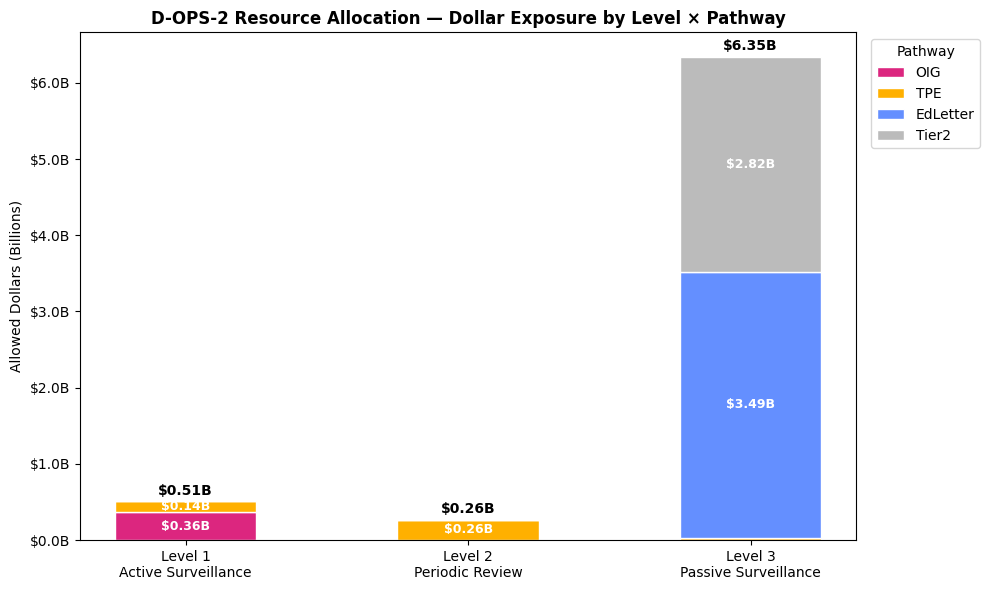

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\resource_exposure_by_cell_v1.png


In [15]:
# =============================================================================
# DOPS2-06-VIZ-02 — Dollar Exposure by Level × Pathway Cell
# Stacked bar chart: allowed dollars by pathway within each monitoring level.
# CVD-compliant IBM Carbon palette.
# =============================================================================

# Pivot for stacking: rows=level_key, cols=pathway_short, values=dollars_billions
pivot_dollars = (
    cell_summary
    .pivot(index="level_key", columns="pathway_short", values="dollars_billions")
    .reindex(index=["Level_1", "Level_2", "Level_3"])
    .fillna(0)
)

# Pathway color map
pathway_colors = {
    "OIG":      "#DC267F",   # magenta
    "TPE":      "#FFB000",   # amber
    "EdLetter": "#648FFF",   # blue
    "Tier2":    "#BBBBBB",   # gray
}

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(3)
x = np.arange(3)
level_labels = ["Level 1\nActive Surveillance", "Level 2\nPeriodic Review", "Level 3\nPassive Surveillance"]

for pathway in ["OIG", "TPE", "EdLetter", "Tier2"]:
    if pathway not in pivot_dollars.columns:
        continue
    vals = pivot_dollars[pathway].values
    bars = ax.bar(
        x, vals, bottom=bottom,
        color=pathway_colors[pathway],
        edgecolor="white", width=0.5,
        label=pathway
    )
    # Label segments > $0.05B
    for i, (val, bot) in enumerate(zip(vals, bottom)):
        if val > 0.05:
            ax.text(
                x[i], bot + val / 2,
                f"${val:.2f}B",
                ha="center", va="center",
                fontsize=9, color="white", fontweight="bold"
            )
    bottom += vals

# Total labels on top
totals = pivot_dollars.sum(axis=1).values
for i, total in enumerate(totals):
    ax.text(
        x[i], total + 0.05,
        f"${total:.2f}B",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

ax.set_title(
    "D-OPS-2 Resource Allocation — Dollar Exposure by Level × Pathway",
    fontsize=12, fontweight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(level_labels, fontsize=10)
ax.set_ylabel("Allowed Dollars (Billions)")
ax.legend(title="Pathway", bbox_to_anchor=(1.01, 1), loc="upper left")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"${v:.1f}B"))

plt.tight_layout()

outpath = OUTPUT_FIGURES / "resource_exposure_by_cell_v1.png"
plt.savefig(outpath, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {outpath}")

In [16]:
# =============================================================================
# DOPS2-07-SENSITIVITY-01 — Sensitivity Analysis
# Test FTE demand under three hour assumption scenarios:
#   Base    : L1=8.0, L2=4.0, L3=0.5  (CONFIG values)
#   Low     : L1=6.0, L2=3.0, L3=0.25 (optimistic — streamlined review)
#   High    : L1=12.0, L2=6.0, L3=1.0 (conservative — complex caseload)
# All scenario parameters declared here — no hardcoded values.
# tag A — sensitivity bounds on operational assumptions.
# =============================================================================

SCENARIOS = {
    "Low":  {"Level_1": 6.0,  "Level_2": 3.0,  "Level_3": 0.25},
    "Base": {"Level_1": HOURS_L1, "Level_2": HOURS_L2, "Level_3": HOURS_L3},
    "High": {"Level_1": 12.0, "Level_2": 6.0,  "Level_3": 1.0},
}

counts = level_summary.set_index("level_key")["provider_count"]

sensitivity_rows = []
for scenario, hours in SCENARIOS.items():
    total_hours = sum(counts[lk] * h for lk, h in hours.items())
    fte_demand  = total_hours / HOURS_PER_FTE
    sensitivity_rows.append({
        "scenario":    scenario,
        "hours_L1":    hours["Level_1"],
        "hours_L2":    hours["Level_2"],
        "hours_L3":    hours["Level_3"],
        "total_hours": total_hours,
        "fte_demand":  fte_demand,
    })

df_sensitivity = pd.DataFrame(sensitivity_rows)

print("=" * PRINT_WIDTH)
print("DOPS2-07-SENSITIVITY-01 — FTE DEMAND SENSITIVITY ANALYSIS")
print("=" * PRINT_WIDTH)
print()
print(
    df_sensitivity.to_string(index=False, float_format=lambda x: f"{x:,.2f}")
)
print()
print("Interpretation:")
print(f"  FTE demand ranges from {df_sensitivity['fte_demand'].min():,.1f} (Low) "
      f"to {df_sensitivity['fte_demand'].max():,.1f} (High) FTEs/quarter")
print(f"  Base assumption: {df_sensitivity.loc[df_sensitivity['scenario']=='Base','fte_demand'].values[0]:,.1f} FTEs/quarter")
print("=" * PRINT_WIDTH)

DOPS2-07-SENSITIVITY-01 — FTE DEMAND SENSITIVITY ANALYSIS

scenario  hours_L1  hours_L2  hours_L3  total_hours  fte_demand
     Low      6.00      3.00      0.25    26,471.25       55.15
    Base      8.00      4.00      0.50    45,068.50       93.89
    High     12.00      6.00      1.00    82,263.00      171.38

Interpretation:
  FTE demand ranges from 55.1 (Low) to 171.4 (High) FTEs/quarter
  Base assumption: 93.9 FTEs/quarter


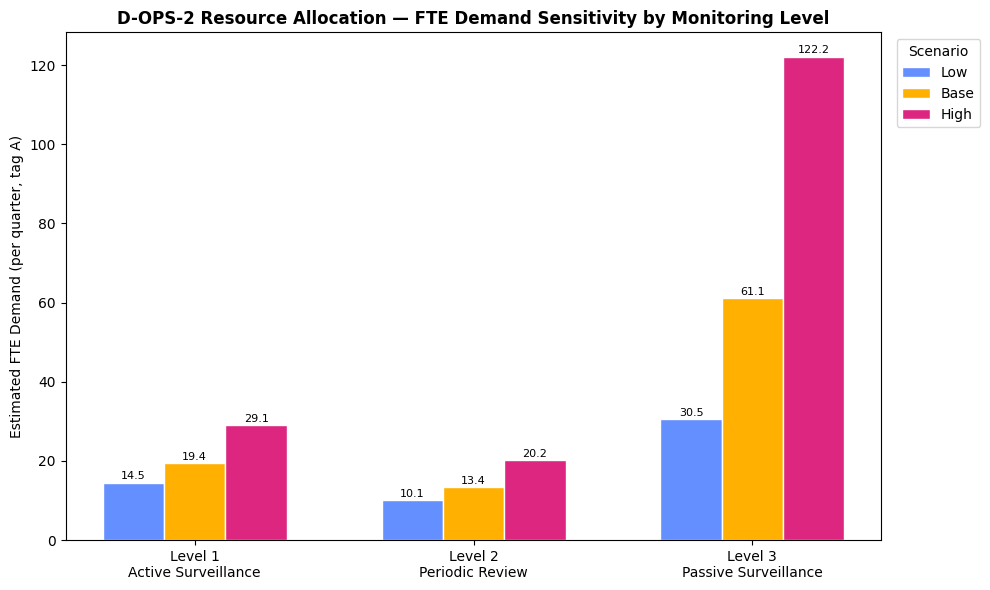

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\resource_sensitivity_v1.png


In [17]:
# =============================================================================
# DOPS2-07-SENSITIVITY-02 — Sensitivity Chart
# Grouped bar chart: FTE demand by monitoring level across three scenarios.
# CVD-compliant IBM Carbon palette.
# =============================================================================

# Build per-level FTE demand for each scenario
scenario_level_rows = []
for scenario, hours in SCENARIOS.items():
    for lk, h in hours.items():
        scenario_level_rows.append({
            "scenario":  scenario,
            "level_key": lk,
            "fte_demand": counts[lk] * h / HOURS_PER_FTE,
        })

df_sens_level = pd.DataFrame(scenario_level_rows)

# Pivot: rows=level_key, cols=scenario
pivot_sens = (
    df_sens_level
    .pivot(index="level_key", columns="scenario", values="fte_demand")
    .reindex(index=["Level_1", "Level_2", "Level_3"])
    [["Low", "Base", "High"]]
)

fig, ax = plt.subplots(figsize=(10, 6))

x           = np.arange(3)
width       = 0.22
level_labels = ["Level 1\nActive Surveillance", "Level 2\nPeriodic Review", "Level 3\nPassive Surveillance"]
scenario_colors = {"Low": "#648FFF", "Base": "#FFB000", "High": "#DC267F"}
offsets = {"Low": -width, "Base": 0, "High": width}

for scenario, color in scenario_colors.items():
    vals = pivot_sens[scenario].values
    bars = ax.bar(
        x + offsets[scenario], vals,
        width=width, color=color,
        edgecolor="white", label=scenario
    )
    for bar, val in zip(bars, vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.3,
            f"{val:.1f}",
            ha="center", va="bottom", fontsize=8
        )

ax.set_title(
    "D-OPS-2 Resource Allocation — FTE Demand Sensitivity by Monitoring Level",
    fontsize=12, fontweight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(level_labels, fontsize=10)
ax.set_ylabel("Estimated FTE Demand (per quarter, tag A)")
ax.legend(title="Scenario", bbox_to_anchor=(1.01, 1), loc="upper left")

plt.tight_layout()

outpath = OUTPUT_FIGURES / "resource_sensitivity_v1.png"
plt.savefig(outpath, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {outpath}")

In [18]:
# =============================================================================
# DOPS2-08-OUTPUT-01 — Write Output Files
# Two parquet outputs: full working dataset and level summary table.
# =============================================================================

# Output 1 — Full working dataset with resource columns
out_work = DATA_PROCESSED / "resource_allocation_v1.parquet"
df_work.to_parquet(out_work, index=False)

# Output 2 — Level summary table (provider count, hours, FTE, dollars)
out_summary = DATA_PROCESSED / "resource_level_summary_v1.parquet"
level_summary.to_parquet(out_summary, index=False)

print("=" * PRINT_WIDTH)
print("DOPS2-08-OUTPUT-01 — OUTPUTS WRITTEN")
print("=" * PRINT_WIDTH)
print()
print(f"  resource_allocation_v1.parquet")
print(f"    Rows    : {len(df_work):,}")
print(f"    Columns : {df_work.columns.tolist()}")
print()
print(f"  resource_level_summary_v1.parquet")
print(f"    Rows    : {len(level_summary):,}")
print(f"    Columns : {level_summary.columns.tolist()}")
print()

# Verify files exist and have expected size
for path in [out_work, out_summary]:
    size_kb = path.stat().st_size / 1024
    print(f"  Confirmed: {path.name} — {size_kb:,.1f} KB")

print("=" * PRINT_WIDTH)

DOPS2-08-OUTPUT-01 — OUTPUTS WRITTEN

  resource_allocation_v1.parquet
    Rows    : 61,416
    Columns : ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'tier_source', 'pathway', 'allowed_dollars_sum', 'monitoring_score', 'monitoring_level', 'level_key', 'pathway_short', 'review_hours', 'acu']

  resource_level_summary_v1.parquet
    Rows    : 3
    Columns : ['level_key', 'provider_count', 'total_hours', 'total_acu', 'total_dollars', 'fte_demand', 'dollars_billions', 'pct_providers', 'pct_dollars']

  Confirmed: resource_allocation_v1.parquet — 1,449.5 KB
  Confirmed: resource_level_summary_v1.parquet — 6.0 KB


In [19]:
# =============================================================================
# DOPS2-09-EVIDENCE-01 — Evidence Log Summary
# Print key analytical findings for evidence log transcription.
# All values derived from data — no hardcoded results.
# =============================================================================

print("=" * PRINT_WIDTH)
print("DOPS2-09-EVIDENCE-01 — EVIDENCE SUMMARY")
print("=" * PRINT_WIDTH)

print("""
E-DOPS2-01 | tag O | Monitoring roster input
  Source : monitoring_roster_v1.parquet (D-OPS-1 output)
  Rows   : 61,416 providers (22,400 Tier 1 + 39,016 Tier 2)
  Columns: 7 — NPI, specialty, tier_source, pathway, allowed_dollars_sum,
           monitoring_score, monitoring_level
  Nulls  : 0
""")

print(f"""E-DOPS2-02 | tag D | Provider count by monitoring level
  Level 1 Active Surveillance : {int(level_summary.loc[level_summary.level_key=='Level_1','provider_count'].values[0]):,} providers ({level_summary.loc[level_summary.level_key=='Level_1','pct_providers'].values[0]:.1f}%)
  Level 2 Periodic Review     : {int(level_summary.loc[level_summary.level_key=='Level_2','provider_count'].values[0]):,} providers ({level_summary.loc[level_summary.level_key=='Level_2','pct_providers'].values[0]:.1f}%)
  Level 3 Passive Surveillance: {int(level_summary.loc[level_summary.level_key=='Level_3','provider_count'].values[0]):,} providers ({level_summary.loc[level_summary.level_key=='Level_3','pct_providers'].values[0]:.1f}%)
""")

print(f"""E-DOPS2-03 | tag D | Dollar exposure by monitoring level
  Level 1 Active Surveillance : ${level_summary.loc[level_summary.level_key=='Level_1','dollars_billions'].values[0]:.2f}B ({level_summary.loc[level_summary.level_key=='Level_1','pct_dollars'].values[0]:.1f}%)
  Level 2 Periodic Review     : ${level_summary.loc[level_summary.level_key=='Level_2','dollars_billions'].values[0]:.2f}B ({level_summary.loc[level_summary.level_key=='Level_2','pct_dollars'].values[0]:.1f}%)
  Level 3 Passive Surveillance: ${level_summary.loc[level_summary.level_key=='Level_3','dollars_billions'].values[0]:.2f}B ({level_summary.loc[level_summary.level_key=='Level_3','pct_dollars'].values[0]:.1f}%)
  Total                       : ${level_summary['dollars_billions'].sum():.2f}B
""")

print(f"""E-DOPS2-04 | tag A | Review hour assumptions by monitoring level
  Level 1 : {HOURS_L1} hrs/provider/quarter — full case review cycle
  Level 2 : {HOURS_L2} hrs/provider/quarter — structured follow-through
  Level 3 : {HOURS_L3} hrs/provider/quarter — automated flag and log
  FTE capacity assumed at {HOURS_PER_FTE:.0f} hrs/FTE/quarter (40 hrs/week x 12 weeks)
  No CMS staffing actuals available in public data — assumptions declared explicitly
""")

print(f"""E-DOPS2-05 | tag D | FTE demand by monitoring level (base scenario)
  Level 1 Active Surveillance : {level_summary.loc[level_summary.level_key=='Level_1','fte_demand'].values[0]:.2f} FTEs
  Level 2 Periodic Review     : {level_summary.loc[level_summary.level_key=='Level_2','fte_demand'].values[0]:.2f} FTEs
  Level 3 Passive Surveillance: {level_summary.loc[level_summary.level_key=='Level_3','fte_demand'].values[0]:.2f} FTEs
  Total FTE demand            : {level_summary['fte_demand'].sum():.2f} FTEs/quarter (base scenario)
""")

print(f"""E-DOPS2-06 | tag D | FTE demand sensitivity range
  Low scenario  (L1=6h, L2=3h, L3=0.25h): {df_sensitivity.loc[df_sensitivity.scenario=='Low','fte_demand'].values[0]:.1f} FTEs/quarter
  Base scenario (L1=8h, L2=4h, L3=0.50h): {df_sensitivity.loc[df_sensitivity.scenario=='Base','fte_demand'].values[0]:.1f} FTEs/quarter
  High scenario (L1=12h, L2=6h, L3=1.0h): {df_sensitivity.loc[df_sensitivity.scenario=='High','fte_demand'].values[0]:.1f} FTEs/quarter
  Range: {df_sensitivity['fte_demand'].min():.1f} to {df_sensitivity['fte_demand'].max():.1f} FTEs/quarter
""")

print(f"""E-DOPS2-07 | tag D | Level x Pathway cell population
  Populated cells : {len(cell_summary)} of 12 possible
  Largest cell by provider count : Level 3 Tier2 — {int(cell_summary.loc[cell_summary.pathway_short=='Tier2','provider_count'].values[0]):,} providers
  Largest cell by dollar exposure: Level 3 EdLetter — ${cell_summary.loc[cell_summary.pathway_short=='EdLetter','dollars_billions'].values[0]:.2f}B
  Notable: 556 TPE providers scored into Level 1 — {556/2527*100:.1f}% of all TPE providers
  Notable: 49 OIG providers scored into Level 2 — flagged for Decision Owner awareness
""")

print("=" * PRINT_WIDTH)
print("EVIDENCE SUMMARY COMPLETE")
print("=" * PRINT_WIDTH)

DOPS2-09-EVIDENCE-01 — EVIDENCE SUMMARY

E-DOPS2-01 | tag O | Monitoring roster input
  Source : monitoring_roster_v1.parquet (D-OPS-1 output)
  Rows   : 61,416 providers (22,400 Tier 1 + 39,016 Tier 2)
  Columns: 7 — NPI, specialty, tier_source, pathway, allowed_dollars_sum,
           monitoring_score, monitoring_level
  Nulls  : 0

E-DOPS2-02 | tag D | Provider count by monitoring level
  Level 1 Active Surveillance : 1,162 providers (1.9%)
  Level 2 Periodic Review     : 1,613 providers (2.6%)
  Level 3 Passive Surveillance: 58,641 providers (95.5%)

E-DOPS2-03 | tag D | Dollar exposure by monitoring level
  Level 1 Active Surveillance : $0.51B (7.1%)
  Level 2 Periodic Review     : $0.26B (3.7%)
  Level 3 Passive Surveillance: $6.35B (89.2%)
  Total                       : $7.12B

E-DOPS2-04 | tag A | Review hour assumptions by monitoring level
  Level 1 : 8.0 hrs/provider/quarter — full case review cycle
  Level 2 : 4.0 hrs/provider/quarter — structured follow-through
  Level 3 :